# Latent Space Models for Neural Data

Many scientific fields involve the study of network data, including
social networks, networks in statistical physics, biological
networks, and information networks
(Goldenberg, Zheng, Fienberg, & Airoldi, 2010; Newman, 2010).

What we can learn about nodes in a network from their connectivity patterns?
We can begin to study this using a latent space model (Hoff, Raftery, & Handcock, 2002).
Latent space models embed nodes in the network in a latent space,
where the likelihood of forming an edge between two nodes depends on
their distance in the latent space.

We will analyze network data from neuroscience.
A webpage version is available at
http://edwardlib.org/tutorials/latent-space-models.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal, Poisson
from observations import celegans

## Data

The data comes from [Mark Newman's repository](http://www-personal.umich.edu/~mejn/netdata/).
It is a weighted, directed network representing the neural network of
the nematode
[C. Elegans](https://en.wikipedia.org/wiki/Caenorhabditis_elegans)
compiled by Watts & Strogatz (1998) using experimental data
by White, Southgate, Thomson, & Brenner (1986).

The neural network consists of around $300$ neurons. Each connection
between neurons
is associated with a weight (positive integer) capturing the strength
of the connection.

First, we load the data.

In [2]:
x_train = celegans("~/data")
#x_train = x_data[:148,:148]
#x_test = x_data[148:296,148:296]

## Model

What can we learn about the neurons from their connectivity patterns? Using
a latent space model (Hoff et al., 2002), we will learn a latent
embedding for each neuron to capture the similarities between them.

Each neuron $n$ is a node in the network and is associated with a latent
position $z_n\in\mathbb{R}^K$.
We place a Gaussian prior on each of the latent positions.

The log-odds of an edge between node $i$ and
$j$ is proportional to the Euclidean distance between the latent
representations of the nodes $|z_i- z_j|$. Here, we
model the weights ($Y_{ij}$) of the edges with a Poisson likelihood.
The rate is the reciprocal of the distance in latent space. The
generative process is as follows:

1. 
For each node $n=1,\ldots,N$,
\begin{align}
z_n \sim N(0,I).
\end{align}
2. 
For each edge $(i,j)\in\{1,\ldots,N\}\times\{1,\ldots,N\}$,
\begin{align}
Y_{ij} \sim \text{Poisson}\Bigg(\frac{1}{|z_i - z_j|}\Bigg).
\end{align}

In Edward, we write the model as follows.

In [5]:
N = x_train.shape[0]  # number of data points
K = 6  # latent dimensionality

z = Normal(loc=tf.zeros([N, K]), scale=tf.ones([N, K]))

# Calculate N x N distance matrix.
# 1. Create a vector, [||z_1||^2, ||z_2||^2, ..., ||z_N||^2], and tile
# it to create N identical rows.
xp = tf.tile(tf.reduce_sum(tf.pow(z, 2), 1, keep_dims=True), [1, N])
# 2. Create a N x N matrix where entry (i, j) is ||z_i||^2 + ||z_j||^2
# - 2 z_i^T z_j.
xp = xp + tf.transpose(xp) - 2 * tf.matmul(z, z, transpose_b=True)
# 3. Invert the pairwise distances and make rate along diagonals to
# be close to zero.
xp = 1.0 / tf.sqrt(xp + tf.diag(tf.zeros(N) + 1e3))

x = Poisson(rate=xp)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Inference

Maximum a posteriori (MAP) estimation is simple in Edward. Two lines are
required: Instantiating inference and running it.

In [6]:
inference = ed.MAP([z], data={x: x_train})

/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


See this extended tutorial about
[MAP estimation in Edward](http://edwardlib.org/tutorials/map).

One could instead run variational inference. This requires specifying
a variational model and instantiating `KLqp`.

In [4]:
#Alternatively, run
qz = Normal(loc=tf.get_variable("qz/loc", [N, K]),
             scale=tf.nn.softplus(tf.get_variable("qz/scale", [N, K])))

In [5]:
inference = ed.KLqp({z: qz}, data={x: x_train})

/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


See this extended tutorial about
[variational inference in Edward](http://edwardlib.org/tutorials/variational-inference).

Finally, the following line runs the inference procedure for 2500
iterations.

In [6]:
inference.run(n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 11899.438

In [7]:
# build posterior predictive after inference: it is
# parameterized by a posterior sample
x_post = ed.copy(x, {z: qz})

In [9]:
# log-likelihood performance
x_test = tf.cast(x_test, tf.float32)
ed.evaluate(['log_loss','log_likelihood'], data={x_post: x_test})

[0.8053268, -0.4644984]

In [8]:
train_loss = [11977.5,11858.1,12096.3,12232.8,12992.3,13738.7]
train_k = [3,6,9,12,30,60]
test_log_loss = [0.81370974,0.80406153,0.7961016,0.7887505,0.75811666,0.73667634]

## Acknowledgments

We thank Maja Rudolph for writing the initial version of this
tutorial.

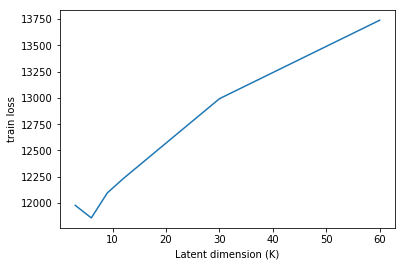

In [15]:
plt.plot(train_k,train_loss)
plt.ylabel('train loss')
plt.xlabel('Latent dimension (K)')
plt.show()

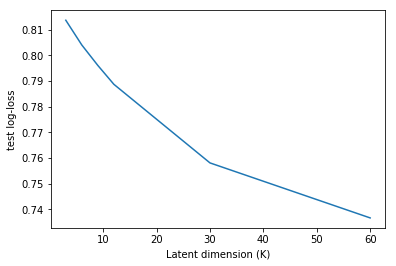

In [17]:
plt.plot(train_k,test_log_loss)
plt.ylabel('test log-loss')
plt.xlabel('Latent dimension (K)')
plt.show()

In [ ]:
test_loss = []
for i in range(1,100):
    tf.reset_default_graph()
        
    N = x_train.shape[0]  # number of data points
    K = i  # latent dimensionality
    z = Normal(loc=tf.zeros([N, K]), scale=tf.ones([N, K]))
    xp = tf.tile(tf.reduce_sum(tf.pow(z, 2), 1, keepdims=True), [1, N])
    xp = xp + tf.transpose(xp) - 2 * tf.matmul(z, z, transpose_b=True)
    xp = 1.0 / tf.sqrt(xp + tf.diag(tf.zeros(N) + 1e3))
    x = Poisson(rate=xp)
    
    inference = ed.MAP([z], data={x: x_train})
    inference.run(n_iter=100)
    
    info_dict = inference.update()
    test_loss.append(info_dict['loss'])
    ed.get_session().close()

/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


100/100 [100%] ██████████████████████████████ Elapsed: 1s | Loss: nan

In [4]:
plt.plot(test_loss)

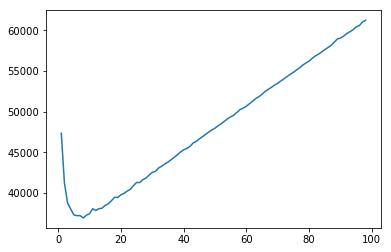

In [5]:
plt.show()